In [5]:
# import statements
import pandas as pd
import numpy as np
from IPython.display import clear_output
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from collections import Counter
from google.colab import files

In [6]:
# download nltk package
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Obtain data from github repository

In [7]:
data_url = 'https://raw.githubusercontent.com/owl0108/MAIS202-Final-Project/master/data/train.tsv'
org_df = pd.read_table(data_url)
# display
org_df.iloc[:20]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [8]:
# only extract rows with full review and reset indices
data_df = org_df.loc[:, ['SentenceId', 'Phrase', 'Sentiment']].drop_duplicates(subset='SentenceId').drop('SentenceId', axis=1).reset_index(drop=True)
# display
data_df.iloc[:20]


,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,"This quiet , introspective and entertaining in...",4
2,"Even fans of Ismail Merchant 's work , I suspe...",1
3,A positively thrilling combination of ethnogra...,3
4,Aggressive self-glorification and a manipulati...,1
5,A comedy-drama of nearly epic proportions root...,4
6,"Narratively , Trouble Every Day is a plodding ...",1
7,"The Importance of Being Earnest , so thick wit...",3
8,But it does n't leave you with much .,1
9,You could hate it for the same reason .,1


# List of helper functions for preprocessing

In [9]:
def clean(review):
  '''(str) -> str
  Remove punctuation, numbers
  '''

  review = review.lower() # lowercase
  review = re.sub("[^A-Za-z ]", '', review) #remove non-alphabetic characters but preserve apostrophe
  return review

In [10]:
# tokenization and clean each token
def tokenize(review):
  '''(str) -> list
  Tokenize the given string: convert it into list of words.
  '''
  tokenized = word_tokenize(review)
  tagged = nltk.pos_tag(tokenized)
  new_tokenized = list()
  
  # clean() is applied after tokenization to split shortend words properly
  # If clean() is applied before tokenization, "I'm" becomes "Im" and will be stored as one token.
  for word in tokenized:
    new_tokenized.append(clean(word))
  return new_tokenized

In [11]:
# remove stop words
def rmv_stopwd(tokenized):
  '''(list) -> list
  From the list of words, remove the stop words provided by nltk library.
  '''
  stop_list = stopwords.words('english')
  return [word for word in tokenized if word not in stop_list]

In [12]:
def convert_tag(tag):
  '''(str) -> str
  Convert tags associated by nltk.pos_tag into the format which lemmatizer.lemmatize understands
  Used in lemmatize() function
  '''
  if tag.startswith('V'): string = 'v'
  elif tag.startswith('J'): string = 'a'
  elif tag.startswith('R'): string = 'r'
  else: string = 'n'
  return string

In [13]:
def lemmatize(tokenized):
  '''(list) -> list
  Given the list of words, lemmatize each word in the list and return a new list.
  Depending on the result of lemmatization, duplicates of the same word may exist in the returned list.
  '''
  tagged = nltk.pos_tag(tokenized)
  lemmatizer = WordNetLemmatizer() 
  lmt = list()
  for word, tag in tagged:
    new_tag = convert_tag(tag)
    lemmatized = lemmatizer.lemmatize(word, pos=new_tag)
    lmt.append(lemmatized)
  return lmt

In [14]:
def get_vacab(review):
  '''(str) -> list
  Given string, the function returns the list of words appearing in the given string.
  '''
  tokenized = tokenize(review)
  tokenized = rmv_stopwd(tokenized)
  tokenized = list(filter(None, tokenized))
  tokenized = lemmatize(tokenized)

  return tokenized

In [15]:
def get_bow(review_vocab, feature_vocab):
  '''(list, list) -> list
  Given the list of words(=vocabulary), the function returns binary-bag-of-words.
  '''
  bow_list = list()
  for word in feature_vocab:
    if word in review_vocab:
      bow_list.append(1)
    else:
      bow_list.append(0)
  return bow_list

## Create feature_vocab in order to create BoW expression.

In [16]:
# create vocabulary for the entire dataset and create FreqDist
# len(freq) is 13648
processed = get_vacab(data_df.Phrase.str.cat(sep=' '))
freq = nltk.FreqDist(processed)

# choose the length of BoW
freq = freq.most_common(10000)

# create feature_vocab
feature_vocab = list()
for word, num in freq:
  feature_vocab.append(word)

## Create vocabulary for each row

In [17]:
review_ser = data_df.Phrase
# make a new column
data_df['vocabulary'] = ''
for i, review in enumerate(review_ser):
  data_df.at[i, 'vocabulary'] = get_vacab(review)

## Create BoW for each row

In [18]:
vocab_ser = data_df.vocabulary
# make a new column
data_df['BoW'] = ''
for i, vocab in enumerate(vocab_ser):
  data_df.at[i, 'BoW'] = get_bow(vocab, feature_vocab)

## Create train, validation, and test datasets

In [19]:
# show data_df after preprocessing
data_df.iloc[:20]

,Phrase,Sentiment,vocabulary,BoW
0,A series of escapades demonstrating the adage ...,1,"[series, escapades, demonstrating, adage, good...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ..."
1,"This quiet , introspective and entertaining in...",4,"[quiet, introspective, entertaining, independe...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"Even fans of Ismail Merchant 's work , I suspe...",1,"[even, fan, ismail, merchant, work, suspect, w...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
3,A positively thrilling combination of ethnogra...,3,"[positively, thrill, combination, ethnography,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Aggressive self-glorification and a manipulati...,1,"[aggressive, selfglorification, manipulative, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,A comedy-drama of nearly epic proportions root...,4,"[comedydrama, nearly, epic, proportion, root, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
6,"Narratively , Trouble Every Day is a plodding ...",1,"[narratively, trouble, every, day, plod, mess]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"The Importance of Being Earnest , so thick wit...",3,"[importance, earnest, thick, wit, play, like, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,But it does n't leave you with much .,1,"[nt, leave, much]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
9,You could hate it for the same reason .,1,"[could, hate, reason]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [20]:
# split dataset into 3
xy_df = pd.DataFrame()
xy_df['x'] = data_df.BoW
xy_df['y'] = data_df.Sentiment

train_df = xy_df.iloc[:5600]
vld_df = xy_df.iloc[5600:6800].reset_index(drop=True)
test_df = xy_df.iloc[6800:].reset_index(drop=True)

# Training Step

In [21]:
# import for training
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [22]:
def check_accuracy(pred, true_val):
  '''
  For checking the accuracy of the prediction.
  '''
  # accuracy score
  print('Accuracy score: ', accuracy_score(true_val, pred))
  # mean squared error
  print('Mean squared error: ', ((true_val - pred)**2).mean())

  # confusioin matrix
  print("\nConfusion matrix: ")
  print("x_label: predicted    y_label: known")
  cm = confusion_matrix(true_val, pred)
  print("\n", cm, "\n")
  sns.heatmap(cm, cmap="Blues")

In [24]:
# create numpy arrays
x_train = np.array(train_df.x.to_list())
y_train = np.array(train_df.y.to_list())
x_vld = np.array(vld_df.x.to_list())
y_vld = np.array(vld_df.y.to_list())
x_test = np.array(test_df.x.to_list())
y_test = np.array(test_df.y.to_list())

## Multinomial Naive Bayes

Accuracy score:  0.39
Mean squared error:  1.5033333333333334

Confusion matrix: 
x_label: predicted    y_label: known

 [[ 25  21   5   6   0]
 [ 89 178  79  58  26]
 [ 12  33  33  26  10]
 [ 24  77 103 183 106]
 [  2   9  12  34  49]] 



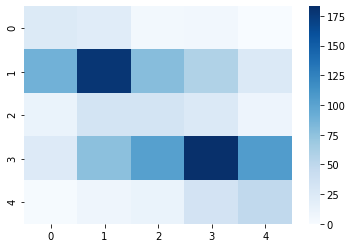

In [39]:
clf = MultinomialNB(alpha=1.0)
clf.fit(x_train,y_train)
y_vld_pred = clf.predict(x_vld)
check_accuracy(y_vld, y_vld_pred)

Accuracy score:  0.38345864661654133
Mean squared error:  1.5240023134759977

Confusion matrix: 
x_label: predicted    y_label: known

 [[ 24  38  14   5   2]
 [138 238 117 108  32]
 [ 17  55  52  41  13]
 [ 36  97 118 283 149]
 [  3  11  25  47  66]] 



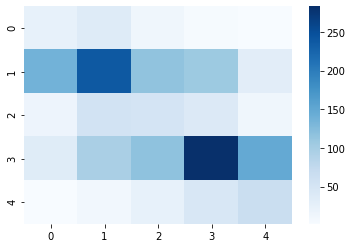

In [40]:
y_test_pred = clf.predict(x_test)
check_accuracy(y_test, y_test_pred)

## Logistic Regression

In [41]:
%%time
clf2 = LogisticRegression(solver='sag', multi_class='multinomial')
clf2.fit(x_train, y_train)

CPU times: user 1min 6s, sys: 465 ms, total: 1min 6s
Wall time: 1min 6s


Accuracy score:  0.3825
Mean squared error:  1.5341666666666667

Confusion matrix: 
x_label: predicted    y_label: known

 [[ 41  60  31  17   3]
 [ 38 145  73  51  11]
 [ 11  65  60  77  19]
 [  8  53  52 149  45]
 [  3  19  25  80  64]] 



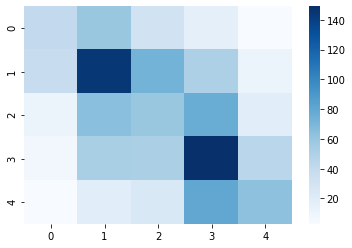

In [43]:
y_vld_pred2 = clf2.predict(x_vld)
check_accuracy(y_vld_pred2, y_vld)

Accuracy score:  0.36205899363794103
Mean squared error:  1.6321573163678427

Confusion matrix: 
x_label: predicted    y_label: known

 [[ 44 106  30  31   7]
 [ 54 199  91  69  26]
 [ 15 101  90  96  24]
 [ 10  86  91 217  80]
 [  4  35  22 125  76]] 



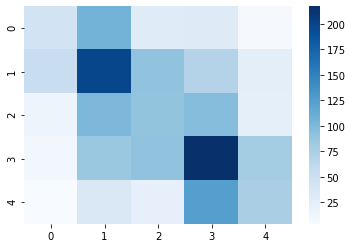

In [44]:
y_test_pred2 = clf2.predict(x_test)
check_accuracy(y_test_pred2, y_test)

## CategoricalNB (Could not debug index error...)

In [ ]:
clf = CategoricalNB()
clf.fit(x_train,y_train)
y_vld_pred = clf.predict(x_vld)
check_accuracy(y_vld, y_vld_pred)

IndexError: ignored

In [ ]:
clf.predict(x_vld[0].reshape(1, -1))

array([3])

In [ ]:
clf.predict(x_vld[1].reshape(1, -1))

IndexError: ignored